In [3]:
! pip install -q kaggle

In [4]:
import cv2
import numpy as np
import os
import random
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib  # To save and load trained models

In [ ]:
# Initialize SIFT
sift = cv2.SIFT_create()
classes = 43  # Number of classes in the dataset

# Storage
data = []
labels = []

# Load images and extract SIFT features
for i in range(classes):
    path = os.path.join('gtsrb-german-traffic-sign/Train', str(i))
    images = os.listdir(path)

    for a in images:
        try:
            # Use OpenCV to load images quickly
            image_path = os.path.join(path, a)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale directly
            if image is None:
                continue

            image = cv2.resize(image, (10, 10))  # Resize for consistency

            # Extract SIFT features
            keypoints, descriptors = sift.detectAndCompute(image, None)
            if descriptors is not None:
                data.append(descriptors.flatten())  # Flatten for SVM
                labels.append(i)

        except Exception as e:
            print(f"Error loading image {a}: {e}")

# Convert lists to NumPy arrays
data = np.array(data, dtype='object')
labels = np.array(labels)

KeyboardInterrupt: 

In [ ]:
random.shuffle(data)

In [ ]:

print(len(data))

In [ ]:
from sklearn.cluster import KMeans

# Define number of visual words (clusters)
NUM_CLUSTERS = 100  # Lowering to 100 clusters to speed up training

# Convert variable-length SIFT descriptors into a single feature vector using K-Means
all_descriptors = np.vstack(data)  # Stack all extracted features
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(all_descriptors)

# Convert images to histograms of visual words
def compute_bovw_features(image_descriptors, kmeans_model, num_clusters=NUM_CLUSTERS):
    """Convert SIFT descriptors into Bag of Visual Words (BoVW) histograms."""
    histogram = np.zeros(num_clusters)
    if image_descriptors is not None:
        cluster_labels = kmeans_model.predict(image_descriptors)  # Assign features to clusters
        for label in cluster_labels:
            histogram[label] += 1
    return histogram

# Transform all training images into histograms
data_bovw = np.array([compute_bovw_features(desc, kmeans) for desc in data])

# Standardize features
scaler = StandardScaler()
data_bovw = scaler.fit_transform(data_bovw)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_bovw, y_encoded, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Save trained model
joblib.dump(svm_model, "svm_traffic_signs.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(kmeans, "kmeans_bovw.pkl")
joblib.dump(scaler, "scaler.pkl")

print("SVM Model trained and saved successfully!")

In [ ]:
def recognize_sign_svm(image, svm_model, kmeans_model, scaler, label_encoder):
    """Recognizes traffic signs using SIFT + BoVW + SVM classification."""
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return "Unknown"

    # Convert descriptors into a BoVW histogram
    bovw_features = compute_bovw_features(descriptors, kmeans_model).reshape(1, -1)
    bovw_features = scaler.transform(bovw_features)

    # Predict using SVM
    predicted_label = svm_model.predict(bovw_features)[0]

    # Convert back to sign name
    recognized_sign = label_encoder.inverse_transform([predicted_label])[0]
    return recognized_sign

In [ ]:
# Load trained models
svm_model = joblib.load("svm_traffic_signs.pkl")
label_encoder = joblib.load("label_encoder.pkl")
kmeans = joblib.load("kmeans_bovw.pkl")
scaler = joblib.load("scaler.pkl")

# Test on a new image
test_image_path = "GTSRB/Test/00000.png"
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (30,30))

recognized_sign = recognize_sign_svm(test_image, svm_model, kmeans, scaler, label_encoder)
print(f"Recognized Sign: {recognized_sign}")

### Sabarish Work

In [7]:
!pip install kaggle

In [67]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [11]:
# Get Kaggle keys to download data
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# Download data from Kaggle competition
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -q
with zipfile.ZipFile("gtsrb-german-traffic-sign.zip", 'r') as zip_ref:
    zip_ref.extractall("GTSRB")

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0


In [75]:
# Define paths
DATASET_PATH = "GTSRB/Train"
CSV_TRAIN_PATH = "GTSRB/Train.csv"
CSV_TEST_PATH = "GTSRB/Test.csv"
TEST_DATASET_PATH = "/content/GTSRB/Test"
N_CLUSTERS = 100  # Number of clusters for BoVW
K_FOLDS = 5  # Number of folds for cross-validation

In [61]:
# Load metadata CSV
df_train = pd.read_csv(CSV_TRAIN_PATH)
df_test = pd.read_csv(CSV_TEST_PATH)

# Define image size (resizing for efficiency)
IMG_SIZE = (64, 64)

# Initialize ORB feature extractor
orb = cv2.ORB_create(nfeatures=500)

# SIFT for comparison
sift = cv2.SIFT_create()

In [62]:
# Mapping class ID to actual traffic sign names
def classify_sign(class_id):
    """Maps class ID to actual traffic sign names."""
    sign_labels = {
        "0": "Speed limit (20km/h)", "1": "Speed limit (30km/h)", "2": "Speed limit (50km/h)",
        "3": "Speed limit (60km/h)", "4": "Speed limit (70km/h)", "5": "Speed limit (80km/h)",
        "6": "End of speed limit (80km/h)", "7": "Speed limit (100km/h)", "8": "Speed limit (120km/h)",
        "9": "No passing", "10": "No passing for vehicles over 3.5 tons", "11": "Right-of-way at intersection",
        "12": "Priority road", "13": "Yield", "14": "Stop", "15": "No vehicles",
        "16": "Vehicles > 3.5 tons prohibited", "17": "No entry", "18": "General caution",
        "19": "Dangerous curve left", "20": "Dangerous curve right", "21": "Double curve",
        "22": "Bumpy road", "23": "Slippery road", "24": "Road narrows on the right",
        "25": "Road work", "26": "Traffic signals", "27": "Pedestrians", "28": "Children crossing",
        "29": "Bicycles crossing", "30": "Beware of ice/snow", "31": "Wild animals crossing",
        "32": "End speed + passing limits", "33": "Turn right ahead", "34": "Turn left ahead",
        "35": "Ahead only", "36": "Go straight or right", "37": "Go straight or left",
        "38": "Keep right", "39": "Keep left", "40": "Roundabout mandatory",
        "41": "End of no passing", "42": "End no passing for vehicles > 3.5 tons"
    }
    return sign_labels.get(str(class_id), "Unknown Traffic Sign")

In [63]:
# Function for Preprocessing (Edge Detection, Histogram Equalization, Grayscale)
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    edges = cv2.Canny(equalized, 50, 150)
    return edges  # Return the preprocessed edge image

In [44]:
# Function for color segmentation (HSV + YCrCb)
def segment_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Define red color ranges (common in traffic signs)
    lower_red1, upper_red1 = np.array([0, 100, 100]), np.array([10, 255, 255])
    lower_red2, upper_red2 = np.array([160, 100, 100]), np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = mask1 + mask2

    # Combine masks with YCrCb segmentation
    ycrcb_mask = cv2.inRange(ycrcb, np.array([0, 135, 85]), np.array([255, 180, 135]))
    combined_mask = cv2.bitwise_or(red_mask, ycrcb_mask)

    return cv2.bitwise_and(image, image, mask=combined_mask)

In [45]:
# Function to detect shape using contours & Hough Transform
def detect_shape(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)

        if len(approx) == 3:
            detected_shapes.append("Triangle")
        elif len(approx) == 4:
            detected_shapes.append("Rectangle")
        else:
            detected_shapes.append("Circle")

    return detected_shapes if detected_shapes else ["Unknown"]

In [38]:
# Function to compute feature histograms for images
def compute_histograms(descriptors_list, kmeans_model, n_clusters):
    histograms = []
    for descriptors in descriptors_list:
        labels = kmeans_model.predict(descriptors)
        hist, _ = np.histogram(labels, bins=n_clusters, range=(0, n_clusters))
        histograms.append(hist)
    return np.array(histograms)

In [70]:
# Function to Load Training Images & Extract ORB Descriptors
def load_images_and_features(dataset_path):
    images, labels, descriptors_list = [], [], []

    for class_id in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_id)

        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            image = cv2.imread(img_path)
            if image is None:
                continue

            # Preprocessing
            segmented_image = segment_color(image)
            processed_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

            # ORB Feature Extraction
            keypoints, descriptors = orb.detectAndCompute(processed_image, None)

            if descriptors is not None and len(descriptors) > 0:
                descriptors_list.append(descriptors)
                images.append(processed_image)
                labels.append(int(class_id))

    return images, labels, descriptors_list

In [71]:
# Load Training Dataset
train_images, train_labels, train_descriptors_list = load_images_and_features(DATASET_PATH)

# Train KMeans for Bag of Visual Words
all_descriptors = np.vstack(train_descriptors_list)
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=1000, random_state=42).fit(all_descriptors)

# Convert Descriptors to BoVW Histograms
X_features = compute_histograms(train_descriptors_list, kmeans, N_CLUSTERS)
y_labels = np.array(train_labels)

In [72]:
# Perform K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
svm = SVC(kernel='linear', C=1.0)

print("\nPerforming K-Fold Cross-Validation...")

fold_accuracies = []
fold_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_features, y_labels)):
    X_train, X_val = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y_labels[train_idx], y_labels[val_idx]

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)

    print(f"Fold {fold+1}: Accuracy = {acc:.2f}, F1-Score = {f1:.2f}")

print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.2f}")
print(f"Average F1-Score: {np.mean(fold_f1_scores):.2f}")


Performing K-Fold Cross-Validation...
Fold 1: Accuracy = 0.35, F1-Score = 0.33
Fold 2: Accuracy = 0.37, F1-Score = 0.35
Fold 3: Accuracy = 0.37, F1-Score = 0.34
Fold 4: Accuracy = 0.35, F1-Score = 0.33
Fold 5: Accuracy = 0.39, F1-Score = 0.36

Average Accuracy: 0.37
Average F1-Score: 0.34


In [48]:
# Save trained models
joblib.dump(svm, "svm_traffic_signs.pkl")
joblib.dump(kmeans, "kmeans_bovw.pkl")

['kmeans_bovw.pkl']

In [73]:
# Load and process test images
def load_test_images(test_path):
    test_images, test_descriptors_list, image_filenames = [], [], []

    for img_file in sorted(os.listdir(test_path)):
        img_path = os.path.join(test_path, img_file)

        image = cv2.imread(img_path)
        if image is None:
            continue

        # Preprocessing
        processed_image = preprocess_image(image)

        # ORB Feature Extraction
        keypoints, descriptors = orb.detectAndCompute(processed_image, None)

        if descriptors is not None and len(descriptors) > 0:
            test_descriptors_list.append(descriptors)
            test_images.append(processed_image)
            image_filenames.append(img_file)

    return test_images, test_descriptors_list, image_filenames

In [76]:
# Load test dataset
test_images, test_descriptors_list, test_filenames = load_test_images(TEST_DATASET_PATH)

# Convert descriptors to BoVW histograms
X_test = np.array([np.histogram(kmeans.predict(desc), bins=N_CLUSTERS, range=(0, N_CLUSTERS))[0] for desc in test_descriptors_list])

# Predict on test data
y_pred = svm.predict(X_test)


Predictions for Test Images:
00006.png -> Predicted: Road narrows on the right
00009.png -> Predicted: Speed limit (30km/h)
00012.png -> Predicted: Speed limit (30km/h)
00022.png -> Predicted: Stop
00042.png -> Predicted: Priority road
00051.png -> Predicted: Speed limit (50km/h)
00052.png -> Predicted: No passing
00054.png -> Predicted: Speed limit (30km/h)
00060.png -> Predicted: Stop
00070.png -> Predicted: Speed limit (50km/h)
00075.png -> Predicted: Speed limit (30km/h)
00082.png -> Predicted: Speed limit (30km/h)
00086.png -> Predicted: Speed limit (50km/h)
00088.png -> Predicted: Priority road
00093.png -> Predicted: Stop
00107.png -> Predicted: Stop
00115.png -> Predicted: Speed limit (70km/h)
00123.png -> Predicted: Stop
00130.png -> Predicted: Priority road
00136.png -> Predicted: General caution
00151.png -> Predicted: Speed limit (30km/h)
00153.png -> Predicted: Stop
00157.png -> Predicted: Priority road
00165.png -> Predicted: Speed limit (30km/h)
00166.png -> Predicted: 

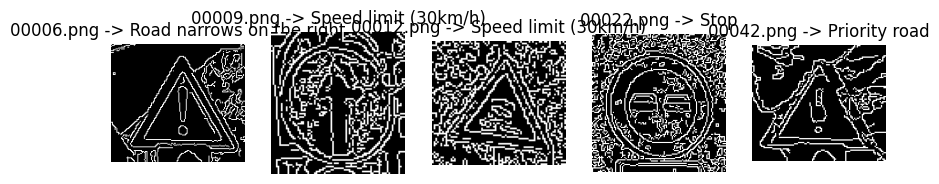

In [77]:
# Print Predictions with Visualization
print("\nPredictions for Test Images:")
for filename, pred_label in zip(test_filenames, y_pred):
    print(f"{filename} -> Predicted: {classify_sign(pred_label)}")

# Visualization Function
def visualize_predictions(images, y_pred, filenames, n_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(min(n_samples, len(images))):
        img = images[i]
        pred_label = y_pred[i]

        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{filenames[i]} -> {classify_sign(pred_label)}")
        plt.axis("off")

    plt.show()

# Visualize Predictions
visualize_predictions(test_images, y_pred, test_filenames)